In [1]:
import os
import re
import shutil
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import numpy as np

from tensorflow import keras


In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

training_set = tf.keras.utils.get_file('train', url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

test_set = tf.keras.utils.get_file('test', url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

training_set_dir = os.path.join(os.path.dirname(training_set), 'train')
test_set_dir = os.path.join(os.path.dirname(test_set), 'test')

6053168/6053168 [==============================] - 1s 0us/step


In [3]:
os.listdir(training_set_dir)

['csharp', 'java', 'javascript', 'python']

In [4]:
sample_file = os.path.join(training_set_dir, 'csharp/72.txt')
with open(sample_file) as f:
  print(f.read())

elegant way to control length of string properties edit: the referenced duplicate is not an option as it was answered 5 years ago (and my reference 6 years ago) and i was hoping there was something more recent that did this rather than hand crafted work around code. nor is the referenced duplicate a fully declarative solution...i have a number of string properties off a class that are only allowed to be a maximum length. coming from a delphi background you were able to define a custom type as:..type tstring10 = string[10];.type tstring50 = string[50];...and then use that as part of a property definition:..property tstring10 mystring.property tstring10 myotherstring.property tstring50 yetotherstring.property tstring50 andthelastone...there appears to be no declarative equivalent in blank that i am aware of? so it appears my only options are:...write manual property setters or getters (that truncate to the specified length).call a validation method that checks the properties to ensure th

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
seed = 999

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'is it safe to use debug folder files for distribution? is it safe to use debug folder files for distribution ? or i should use release folder ...i use vs 2008 express edition .\n'
Label 0
Review b'"copying recursively files in blank i was looking to copy a whole directory and its files but also printing each file name that its being copied...i was using a simply call to cp -rf dir dest with os.system but i cant print each filename separately as obvious...i then thought about listing eash directory file by calling recursively ls with os.system, saving the whole string, split them on an array, and implement a for loop to run os.system(""cp "" file1 + "" des/"") and printing the filename, but it looks like lot of work. ..any better ideas to accomplish this?"\n'
Label 3
Review b'"how to upload a file on server in blank in fast way httpwebrequest request = (httpwebrequest)webrequest.create(""request_uri_string"");.filestream filestream = new filestream(""path_to_my_file"", filemode

In [7]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [8]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=BATCH_SIZE, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [9]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=BATCH_SIZE)

Found 8000 files belonging to 4 classes.


In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(raw_train_ds.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'i', 'to', 'a', 'is', 'in', 'and', 'of', 'if',
       'it', 'for', 'this', 'that', 'new', 'blank', 'have', 'string', '0'],
      dtype='<U22')

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])

In [13]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
epochs = 5

history = model.fit(raw_train_ds, epochs=epochs,
                    validation_data=raw_test_ds,
                    validation_steps=30)

Epoch 1/5
100/100 [==============================] - 177s 2s/step - loss: 1.3855 - accuracy: 0.2770 - val_loss: 1.3845 - val_accuracy: 0.3146
Epoch 2/5
100/100 [==============================] - 165s 2s/step - loss: 1.3813 - accuracy: 0.3486 - val_loss: 1.3775 - val_accuracy: 0.3464
Epoch 3/5
100/100 [==============================] - 161s 2s/step - loss: 1.2824 - accuracy: 0.4336 - val_loss: 1.2058 - val_accuracy: 0.4318
Epoch 4/5
100/100 [==============================] - 162s 2s/step - loss: 1.0844 - accuracy: 0.5025 - val_loss: 1.1013 - val_accuracy: 0.4677
Epoch 5/5
100/100 [==============================] - 159s 2s/step - loss: 1.0225 - accuracy: 0.5277 - val_loss: 1.0184 - val_accuracy: 0.5406


In [15]:
test_loss, test_acc = model.evaluate(raw_test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

125/125 [==============================] - 38s 301ms/step - loss: 0.9962 - accuracy: 0.5420
Test Loss: 0.9962317943572998
Test Accuracy: 0.5419999957084656


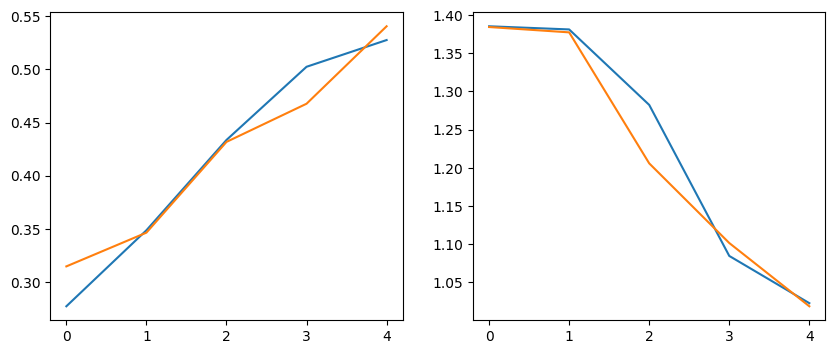

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [17]:
sample_text = ['PyMongo save List of dict in subfield with own ObjectId for every dict entry',
               'Split columns of nested lists into multiple columns in pandas',
               'System.OutOfMemoryException when invoking Dapper\'s QueryAsync<>() method',
               'Does the NEST client, or indeed elasticsearch have a facility to retry delete_by_query, in particular in case of version_conflicts?',
               'querySelectorAll() - Need help returning ONLY certaint elements',
               'How can I use html elements with css animation in javascript?',
               'How to get an ArrayList out of a Field object in Java for Unit test',
               'How to pass columns dynamically for select query in java spring boot?']
print(len(sample_text))
i=0
while i < len(sample_text):
    print(model.predict(np.array([sample_text[i]])))
    i = i + 1

8
1/1 [==============================] - 2s 2s/step
[[-0.08580904 -0.23256914  0.09917156  0.19180638]]
1/1 [==============================] - 0s 23ms/step
[[ 0.04946685 -0.05180544 -0.12132367  0.05878195]]
1/1 [==============================] - 0s 23ms/step
[[ 0.11570095  0.10301193 -0.16011417 -0.12121169]]
1/1 [==============================] - 0s 25ms/step
[[ 0.05152608 -0.03734758 -0.09224032  0.05793831]]
1/1 [==============================] - 0s 26ms/step
[[ 0.0577267  -0.00348192 -0.02713842 -0.06483564]]
1/1 [==============================] - 0s 24ms/step
[[-0.02914293 -0.10397866  0.09554629  0.04045448]]
1/1 [==============================] - 0s 23ms/step
[[ 0.07509007  0.01422931 -0.17929944  0.014533  ]]
1/1 [==============================] - 0s 23ms/step
[[-0.00502464 -0.10974856  0.01871942  0.08084328]]


In [18]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 138,564
Trainable params: 138,564
Non-trai

In [19]:
loss, acc = new_model.evaluate(raw_test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(raw_test_ds).shape)

125/125 - 27s - loss: 0.8302 - accuracy: 0.6291 - 27s/epoch - 217ms/step
Restored model, accuracy: 62.91%
125/125 [==============================] - 31s 227ms/step
(8000, 4)
